# Dynamic Hedging with Reinforcement Learning

## Educational Overview

This notebook demonstrates how **reinforcement learning** can be applied to solve one of the most challenging problems in quantitative finance: **dynamic hedging** of options. 

### Key Concepts:

**Dynamic Hedging** is the practice of continuously adjusting a portfolio to maintain a delta-neutral position (hedging against price movements). In traditional finance:
- We use the **Black-Scholes delta** to determine how many shares to hold
- The goal is to replicate an option's payoff using stocks and bonds
- Perfect hedging is theoretically possible but practically challenging due to transaction costs and discrete rebalancing

**Why Use Reinforcement Learning?**
- Traditional delta hedging assumes constant volatility and continuous rebalancing
- RL can learn optimal hedging strategies that account for:
  - Transaction costs
  - Discrete rebalancing intervals
  - Model uncertainties
  - Market frictions

**What You'll Learn:**
1. How to implement the Black-Scholes model for option pricing
2. How geometric Brownian motion simulates stock price movements
3. How to create a custom RL environment for hedging
4. How to train an agent to minimize hedging errors
5. How RL hedging compares to classical delta hedging

This represents a practical application of RL in quantitative finance, bridging theoretical models with real-world trading constraints.

## Black-Scholes Model Implementation

The **Black-Scholes model** is the foundation of modern option pricing theory. It provides analytical formulas for European option prices and their sensitivities (the "Greeks").

### Mathematical Foundation:
The Black-Scholes formula for a European call option is:

**C = S₀ × N(d₁) - K × e^(-rT) × N(d₂)**

Where:
- **S₀**: Current stock price
- **K**: Strike price
- **T**: Time to maturity
- **r**: Risk-free rate
- **σ**: Volatility
- **N(x)**: Cumulative standard normal distribution
- **d₁, d₂**: Intermediate calculations involving all parameters

### Key Assumptions:
- Constant volatility and interest rate
- No dividends
- European exercise (only at maturity)
- No transaction costs
- Continuous trading possible

### Why This Matters for Hedging:
The Black-Scholes **delta** (∂C/∂S) tells us how many shares we need to hold to hedge against small price movements. However, these assumptions rarely hold in practice, which is where RL can provide value by learning better hedging strategies.

<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 07 &mdash; Dynamic Hedging**

&copy; Dr. Yves J. Hilpisch

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Delta Hedging

In [1]:
import math
import random
import numpy as np
import pandas as pd
from scipy import stats
from pylab import plt, mpl

In [2]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)

## Geometric Brownian Motion (GBM) - The Engine of Price Dynamics

**Geometric Brownian Motion** is the mathematical model that describes how stock prices evolve over time in the Black-Scholes framework.

### The GBM Equation:
**dS = μS dt + σS dW**

Where:
- **dS**: Change in stock price
- **μ**: Expected return (drift)
- **σ**: Volatility 
- **dW**: Random component (Wiener process)
- **dt**: Small time increment

### Discrete Implementation:
In practice, we simulate GBM using discrete time steps:

**S(t+Δt) = S(t) × exp((μ - σ²/2)Δt + σ√Δt × Z)**

Where **Z** is a standard normal random variable.

### Why This Simulation Matters:
1. **Testing Hedging Strategies**: We need realistic price paths to test our RL agent
2. **Market Scenarios**: Different volatility and drift parameters represent different market conditions
3. **Risk Assessment**: Multiple simulations help us understand the distribution of hedging errors

The following code generates these realistic stock price paths that our RL agent will learn to hedge against.

In [3]:
from bsm73 import bsm_call_value

In [4]:
S0 = 100
K = 100
T = 1.
t = 0.
r = 0.05
sigma = 0.2

In [5]:
bsm_call_value(S0, K, T, t, r, sigma)

10.450583572185565

## Understanding Delta Hedging

**Delta hedging** is the cornerstone of option risk management. Let's understand what we're trying to achieve:

### What is Delta (Δ)?
- **Delta** measures how much an option's price changes when the underlying stock price changes by $1
- For a call option: **Δ = ∂C/∂S** (partial derivative of call price with respect to stock price)
- Delta ranges from 0 to 1 for calls, and -1 to 0 for puts

### The Hedging Strategy:
1. **Sell the option** (receive premium)
2. **Buy Δ shares** of the underlying stock
3. **Invest/borrow** the remaining cash at the risk-free rate
4. **Continuously rebalance** as delta changes

### Why Rebalancing is Needed:
- **Delta changes** as the stock price moves (this is called "gamma risk")
- **Time decay** also affects delta
- Without rebalancing, our hedge becomes ineffective

### The Goal:
Create a **self-financing portfolio** that exactly replicates the option payoff, making the option position risk-free.

The following visualization shows how delta varies with different parameters:

In [6]:
random.seed(1000)

In [7]:
def simulate_gbm(S0, T, r, sigma, steps=100):
    gbm = [S0]
    dt = T / steps
    for t in range(1, steps + 1):
        st = gbm[-1] * math.exp((r - sigma ** 2 / 2) * dt
                    + sigma * math.sqrt(dt) * random.gauss(0, 1))
        gbm.append(st)
    return gbm

In [8]:
gbm = simulate_gbm(S0, T, r, sigma)

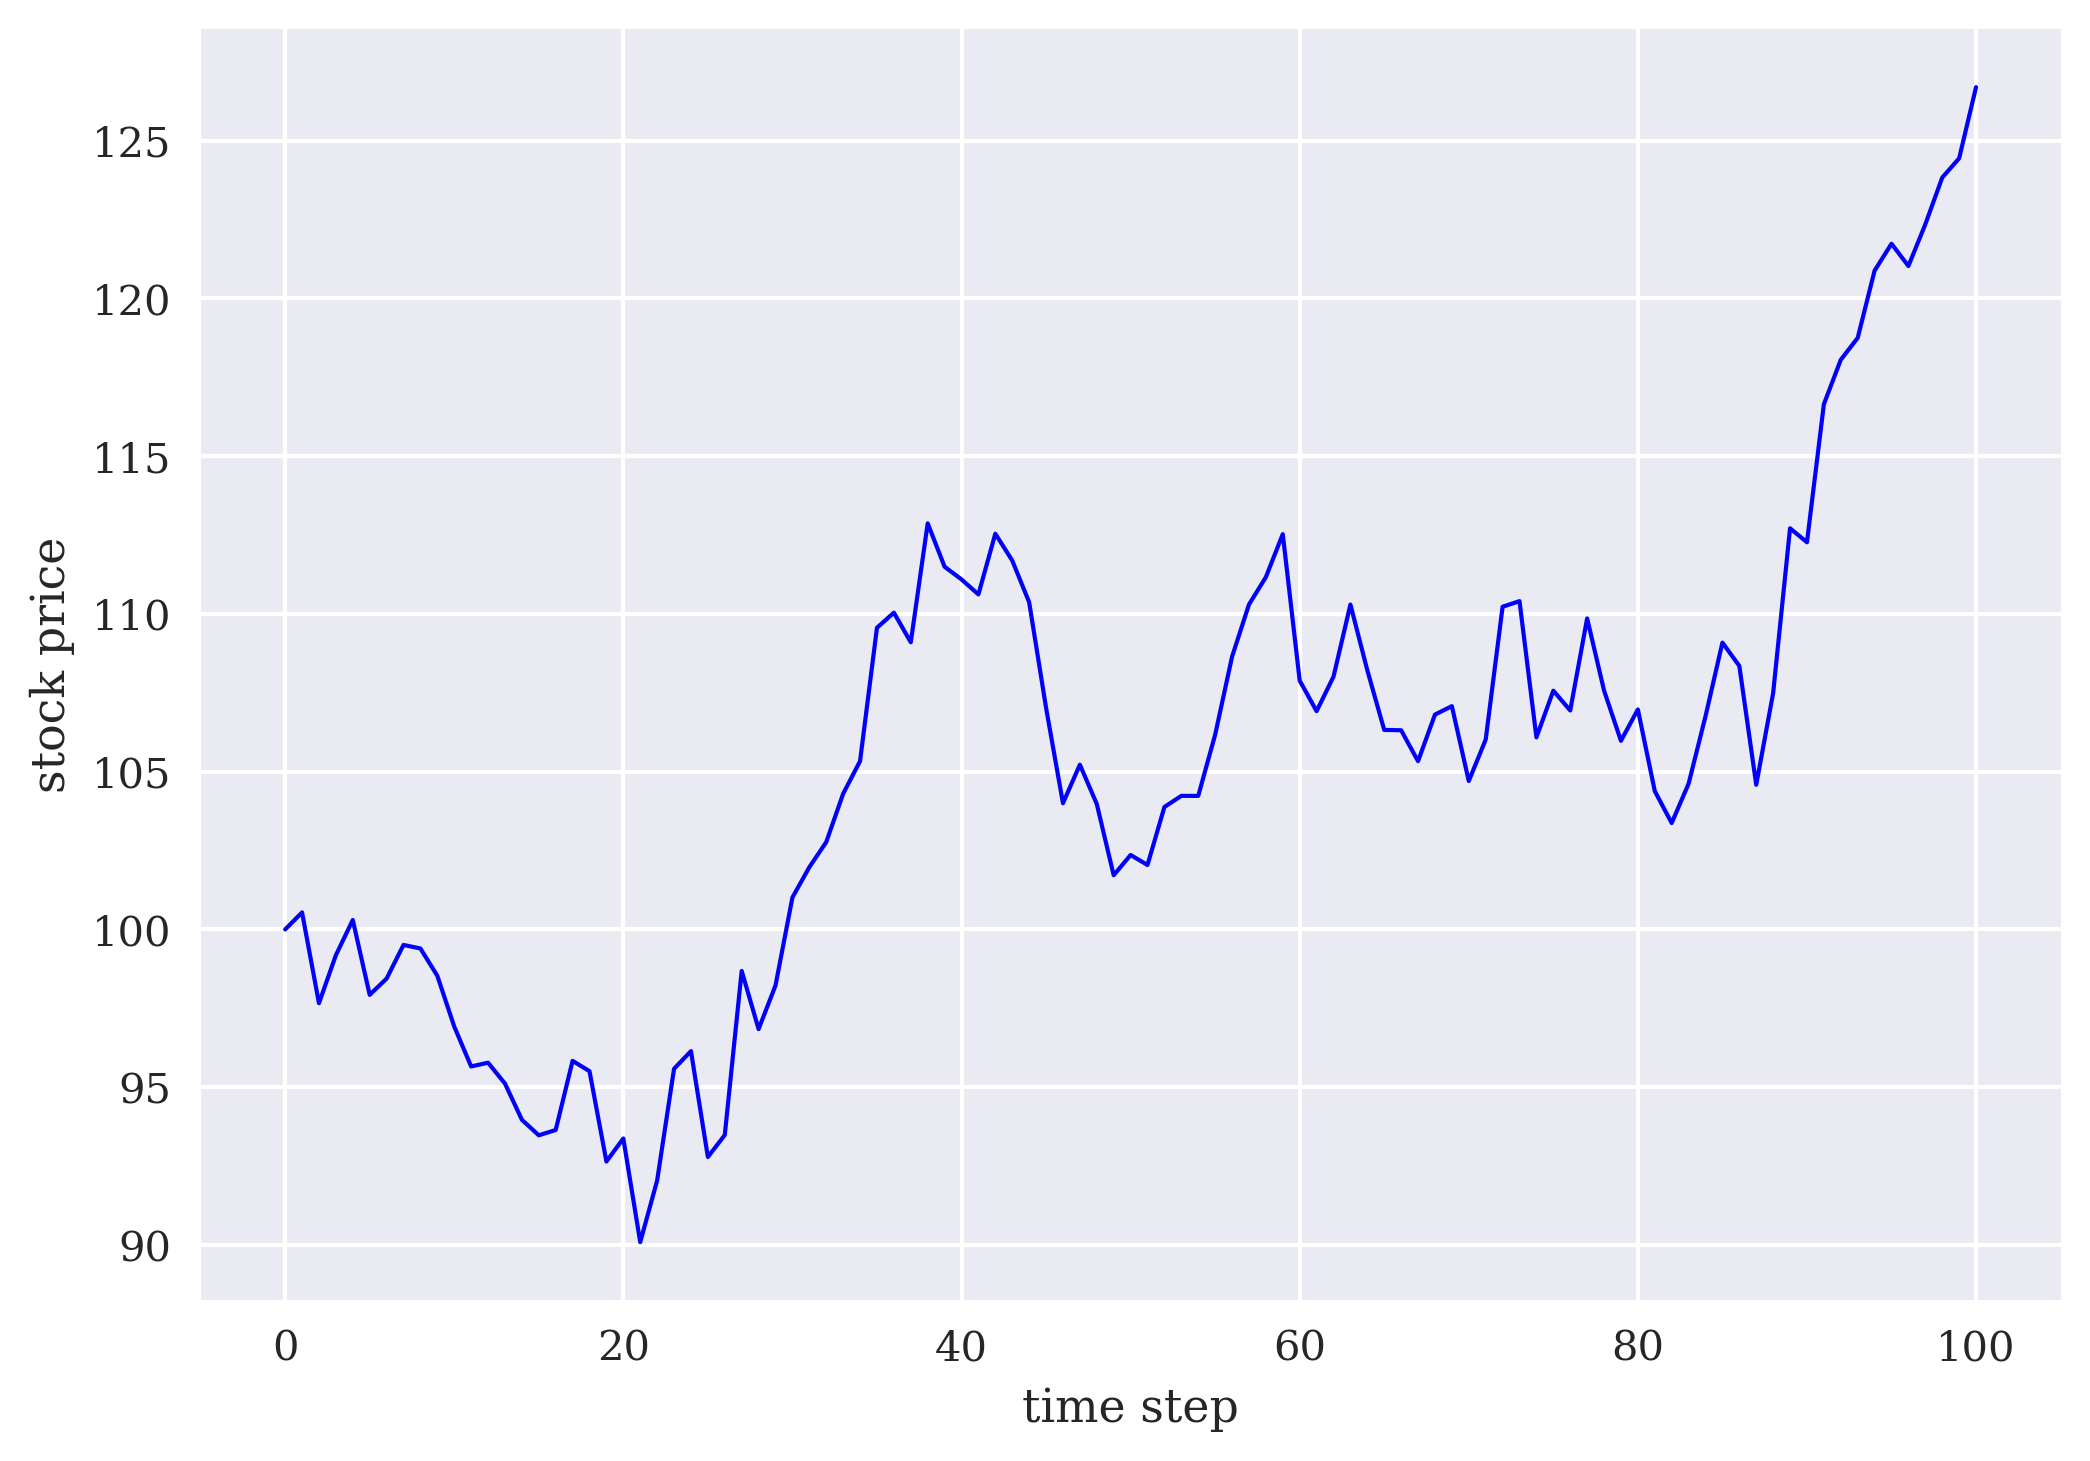

In [9]:
plt.plot(gbm, lw=1.0, c='b')
plt.xlabel('time step')
plt.ylabel('stock price');

In [10]:
def bsm_delta(St, K, T, t, r, sigma):
    d1 = ((math.log(St / K) + (r + 0.5 * sigma ** 2) * (T - t)) /
          (sigma * math.sqrt(T - t)))
    return stats.norm.cdf(d1, 0, 1)

In [11]:
S_ = range(40, 181, 4)

In [12]:
d = [bsm_delta(s, K, T, 0, r, sigma) for s in S_]

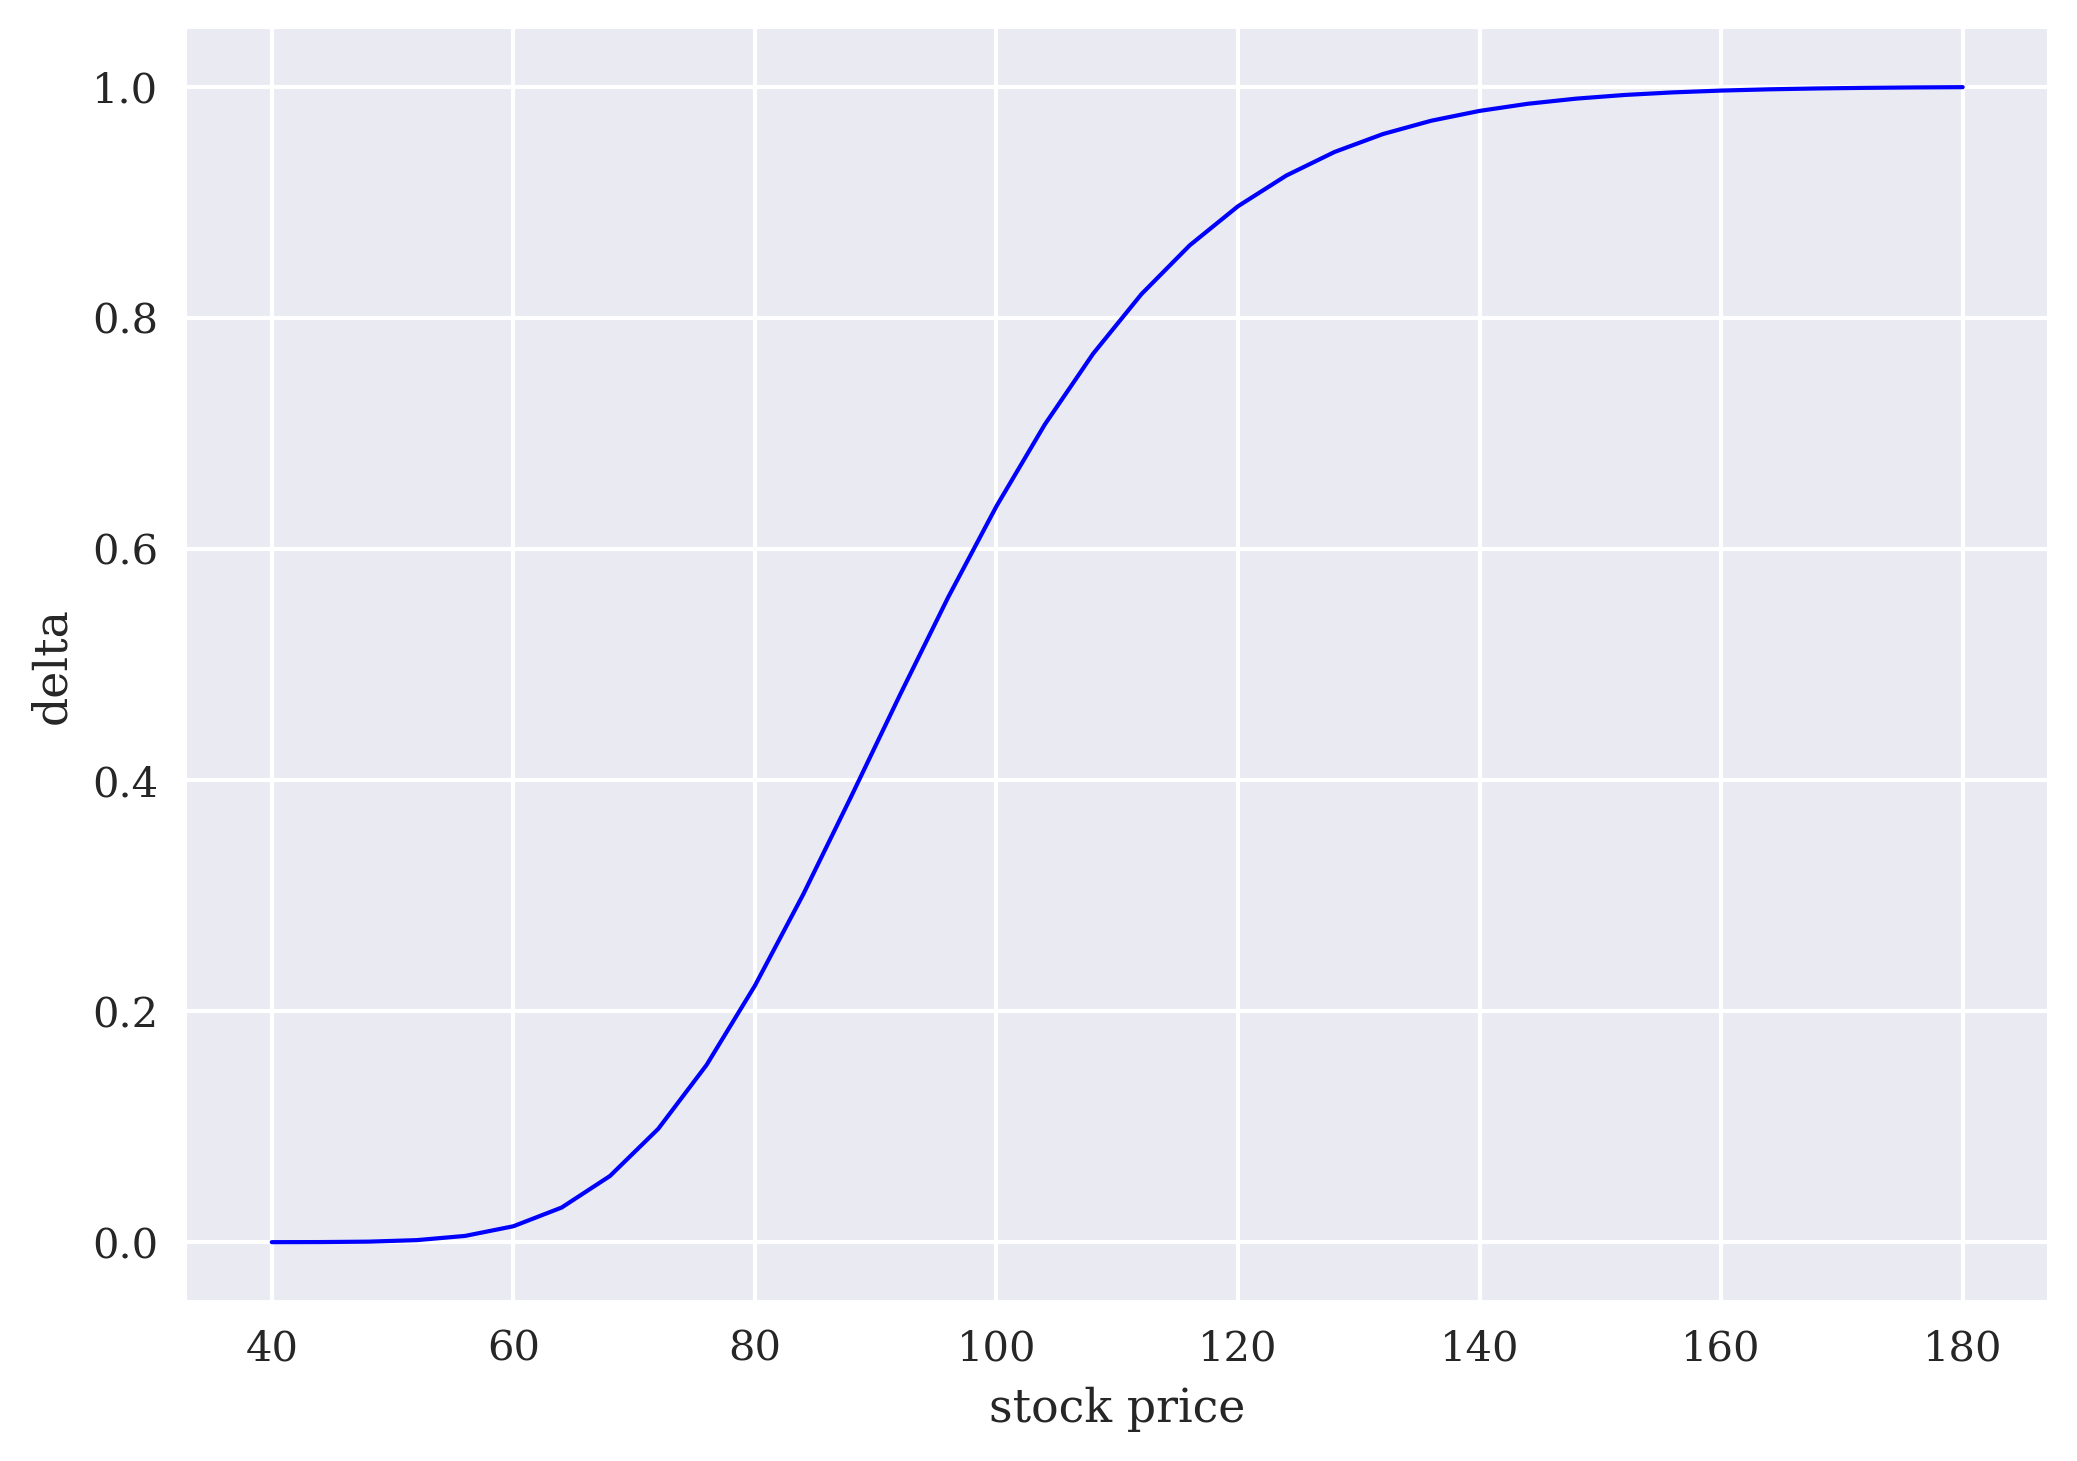

In [13]:
plt.plot(S_, d, lw=1.0, c='b')
plt.xlabel('stock price')
plt.ylabel('delta');

In [14]:
dt = T / (len(gbm) - 1)

In [15]:
bond = [math.exp(r * i * dt) for i in range(len(gbm))]

In [16]:
def option_replication():
    res = pd.DataFrame()
    for i in range(len(gbm) - 1):
        C = bsm_call_value(gbm[i], K, T, i * dt, r, sigma)
        if i == 0:
            s = bsm_delta(gbm[i], K, T, i * dt, r, sigma)
            b = (C - s * gbm[i]) / bond[i]
        else:
            V = s * gbm[i] + b * bond[i]
            s = bsm_delta(gbm[i], K, T, i * dt, r, sigma)
            b = (C - s * gbm[i]) / bond[i]
            df = pd.DataFrame({'St': gbm[i], 'C': C, 'V': V,
                               's': s, 'b': b}, index=[0])
            res = pd.concat((res, df), ignore_index=True)
    return res

In [17]:
res = option_replication()

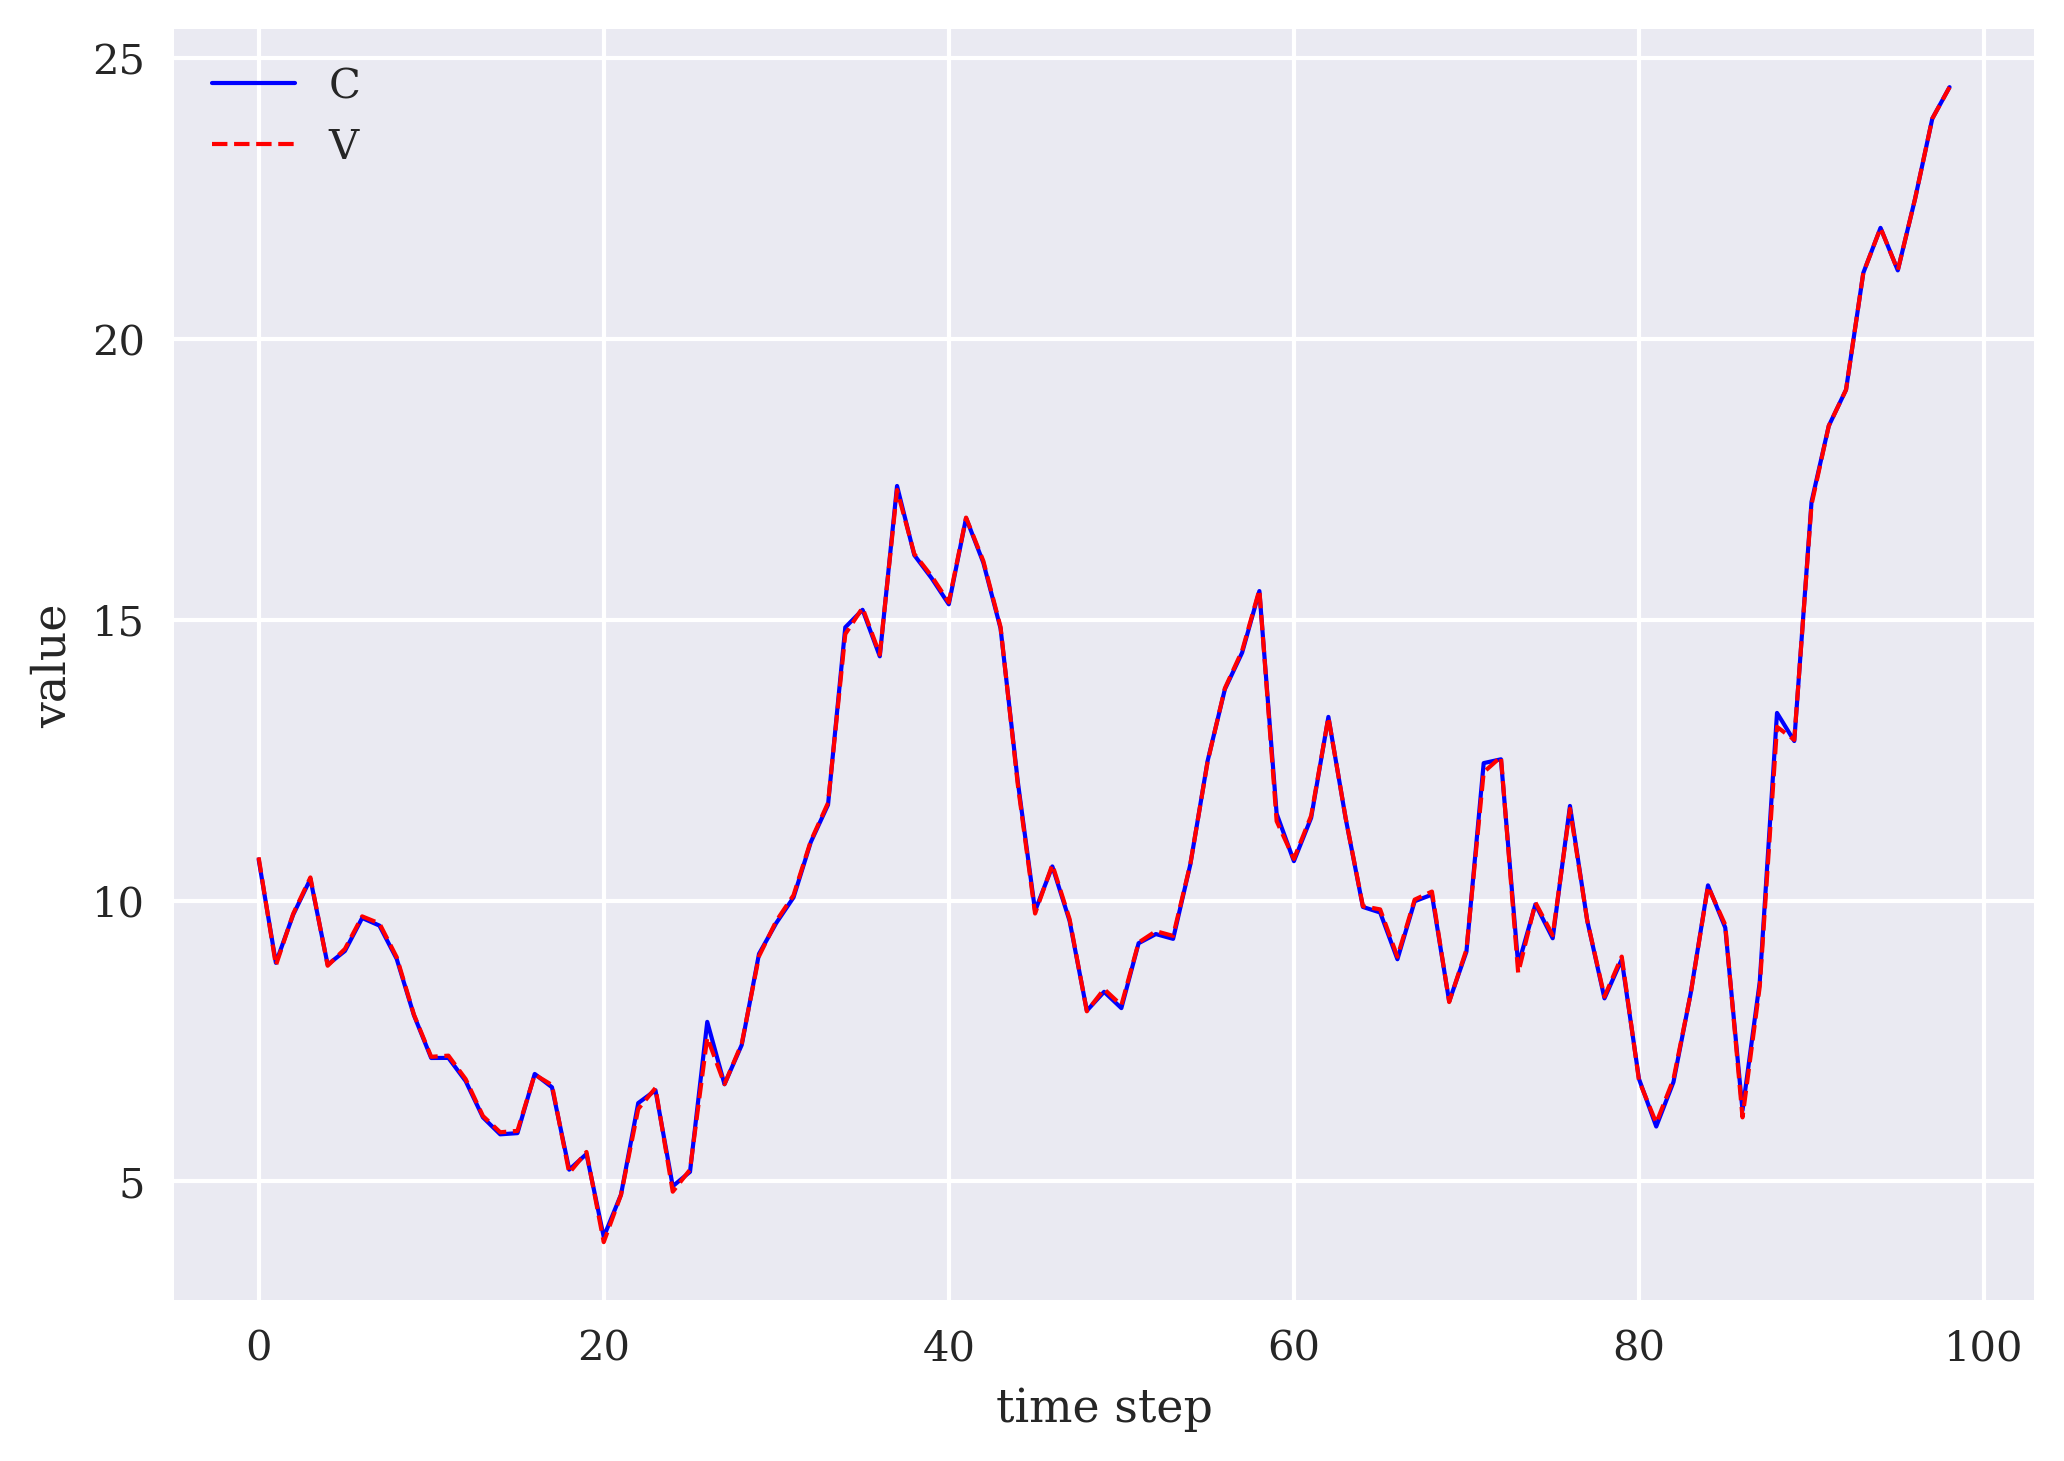

In [18]:
res[['C', 'V']].plot(style=['b', 'r--'], lw=1)
plt.xlabel('time step')
plt.ylabel('value');

In [19]:
(res['V'] - res['C']).mean()

-0.0009828178536543022

In [20]:
((res['V'] - res['C']) ** 2).mean()

0.003755015460265298

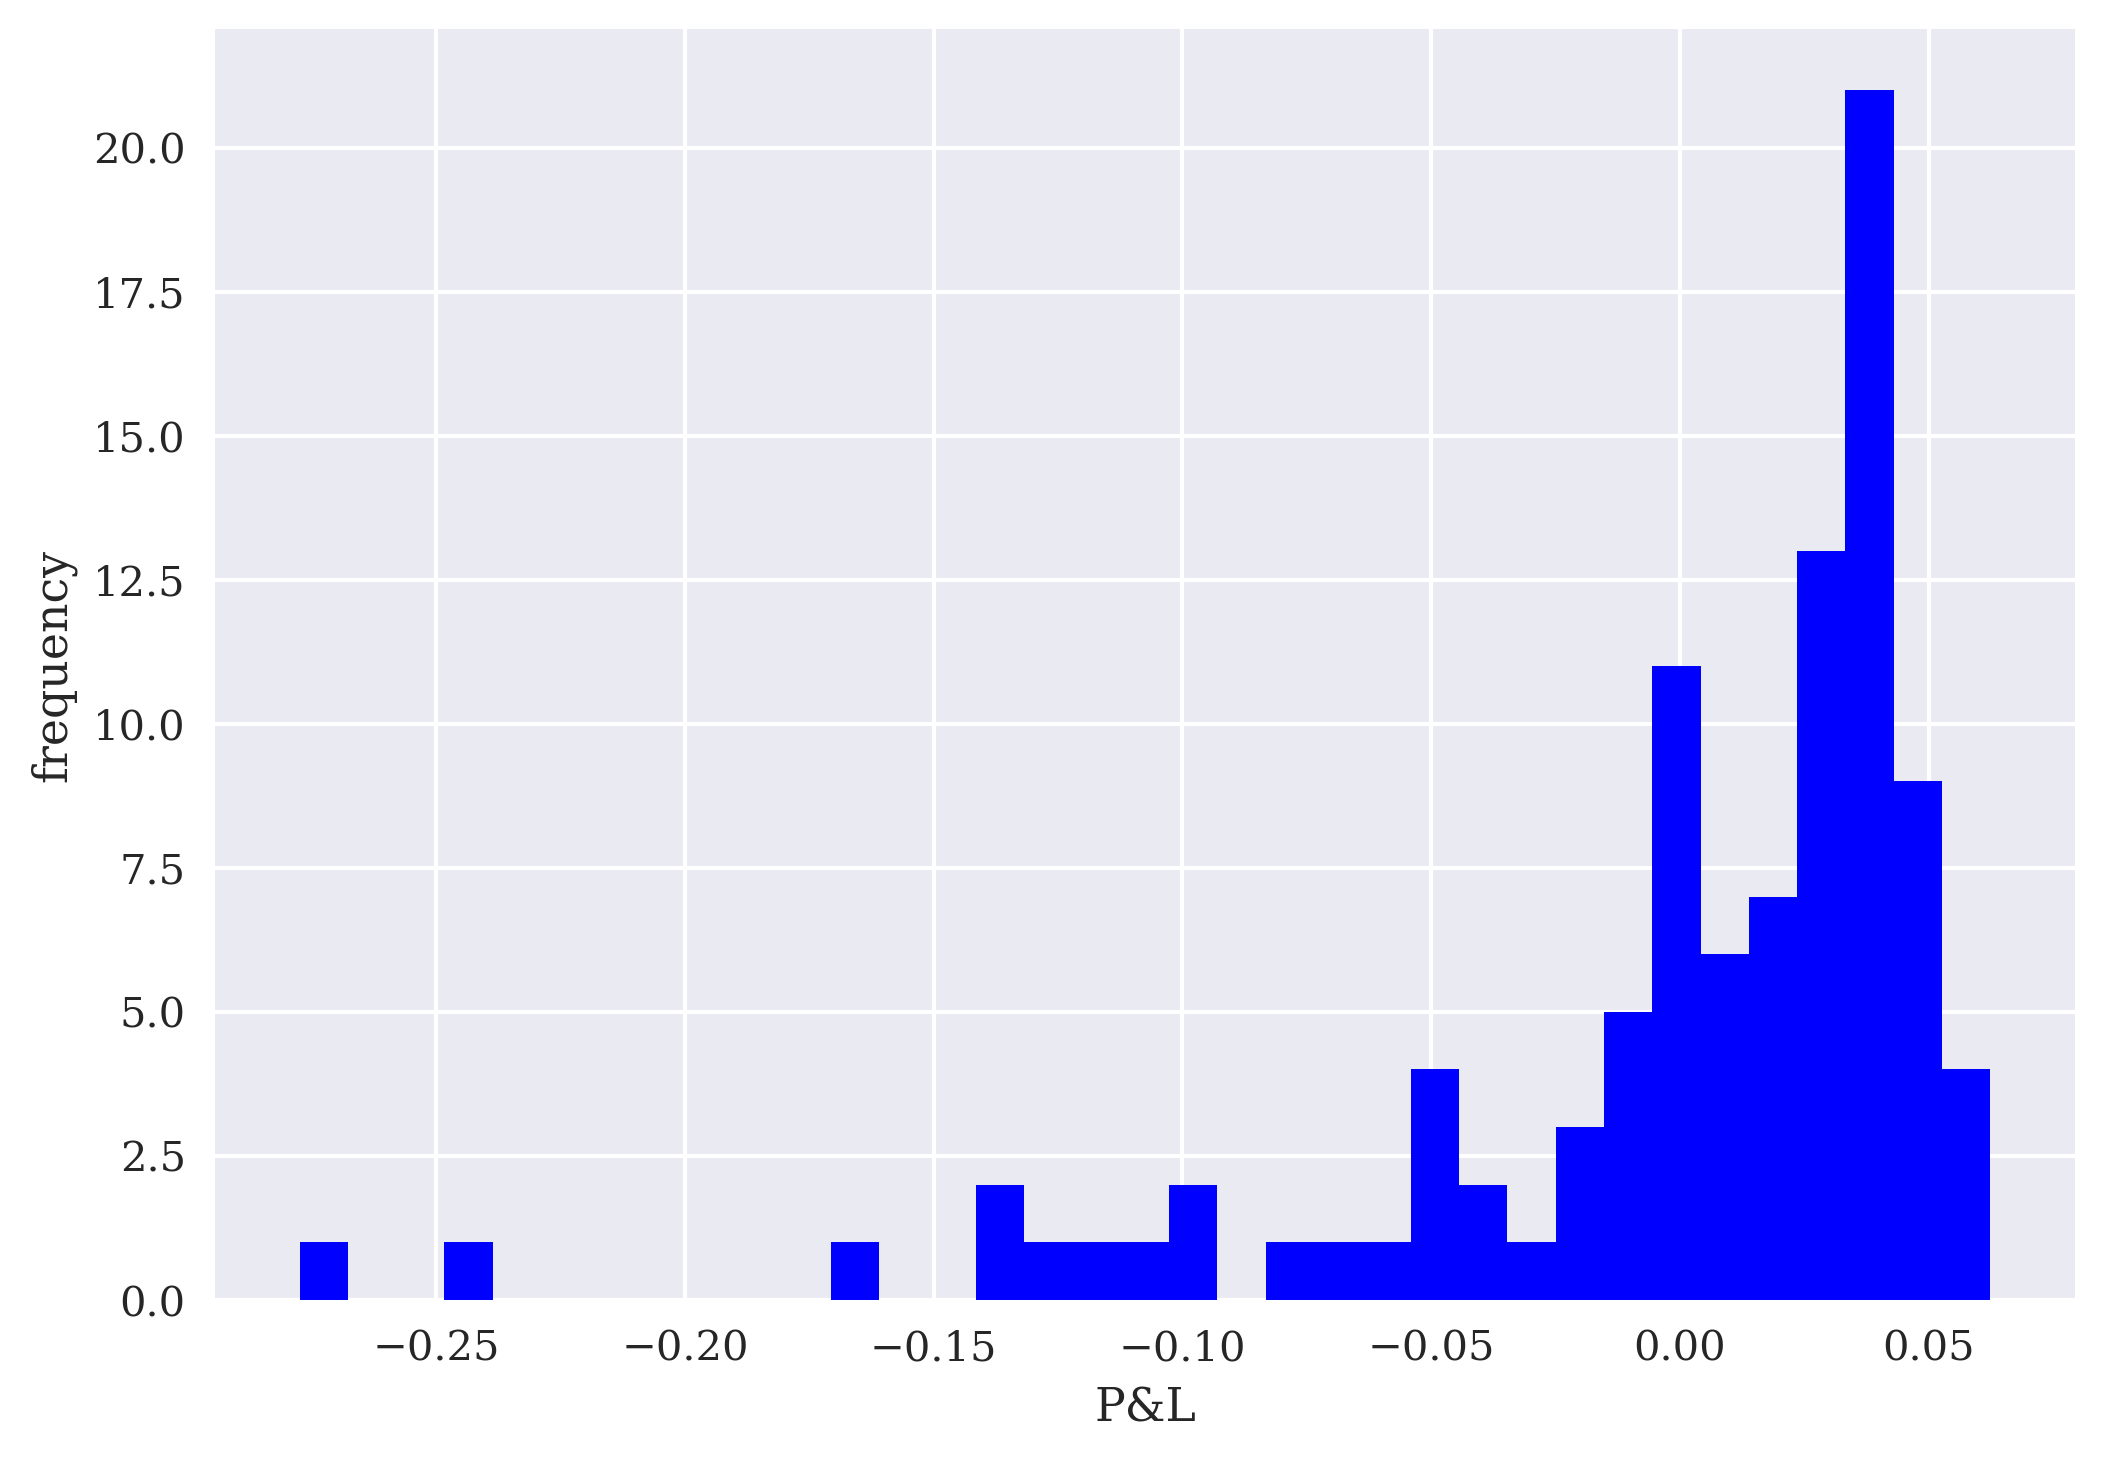

In [21]:
(res['V'] - res['C']).hist(bins=35, color='b')
plt.xlabel('P&L')
plt.ylabel('frequency');

## Hedging Environment

## Creating a Reinforcement Learning Environment for Hedging

Now we'll create a custom **OpenAI Gym-style environment** specifically designed for the hedging problem. This is where RL theory meets practical finance.

### Environment Design Philosophy:

**State Space**: What information does our agent observe?
- Current stock price (S)
- Current bond price (B) 
- Time to maturity (T-t)
- Current option value (C)
- Strike price (K)
- Risk-free rate (r)
- Current stock holding
- Current bond holding

**Action Space**: What can our agent do?
- Choose how many shares to hold (continuous action)
- The bond position is automatically determined to maintain portfolio value

**Reward Function**: How do we measure success?
- **Negative squared hedging error**: -(φ - C)²
- Where φ is portfolio value and C is option value
- This incentivizes the agent to minimize hedging errors

**Episode Structure**:
- Each episode represents hedging one option from issuance to maturity
- Random option parameters (strike, volatility, interest rate) for generalization
- Random stock price paths via GBM simulation

### Key RL Challenges in Hedging:
1. **Continuous action space** (how many shares to hold)
2. **Dynamic environment** (prices change stochastically)
3. **Risk management** (minimizing hedging errors)
4. **Generalization** across different market conditions

This environment allows our RL agent to learn optimal hedging strategies through trial and error across thousands of scenarios.

In [22]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [23]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        random.seed(seed)
    def sample(self):
        return random.random()

In [24]:
class Hedging:
    def __init__(self, S0, K_, T, r_, sigma_, steps):
        self.initial_value = S0
        self.strike_ = K_
        self.maturity = T
        self.short_rate_ = r_
        self.volatility_ = sigma_
        self.steps = steps
        self.observation_space = observation_space(5)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(1)
        self._simulate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0

In [25]:
class Hedging(Hedging):
    def _simulate_data(self):
        s = [self.initial_value]
        self.strike = random.choice(self.strike_)
        self.short_rate = random.choice(self.short_rate_)
        self.volatility = random.choice(self.volatility_)
        self.dt = self.maturity / self.steps
        for t in range(1, self.steps + 1):
            st = s[t - 1] * math.exp(
              ((self.short_rate - self.volatility ** 2 / 2) * self.dt +
                self.volatility * math.sqrt(self.dt) *
                  random.gauss(0, 1)))
            s.append(st)
        self.data = pd.DataFrame(s, columns=['index'])
        self.data['bond'] = np.exp(self.short_rate *
                            np.arange(len(self.data)) * self.dt)

In [26]:
class Hedging(Hedging):
    def _get_state(self):
        St = self.data['index'].iloc[self.bar]
        Bt = self.data['bond'].iloc[self.bar]
        ttm = self.maturity - self.bar * self.dt
        if ttm > 0:
            Ct = bsm_call_value(St, self.strike,
                           self.maturity, self.bar * self.dt,
                           self.short_rate, self.volatility)
        else:
            Ct = max(St - self.strike, 0)
        return np.array([St, Bt, ttm, Ct, self.strike, self.short_rate,
                         self.stock, self.bond]), {} 
    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)
    def reset(self):
        self.bar = 0
        self.bond = 0
        self.stock = 0
        self.treward = 0
        self.episode += 1
        self._simulate_data()
        self.state, _ = self._get_state()
        return self.state, _

In [27]:
class Hedging(Hedging):
    def step(self, action):
        if self.bar == 0:
            reward = 0
            self.bar += 1
            self.stock = float(action)
            self.bond = ((self.state[3] - self.stock * self.state[0]) /
                         self.state[1])
            self.new_state, _ = self._get_state()
        else:
            self.bar += 1
            self.new_state, _ = self._get_state()
            phi_value = (self.stock * self.new_state[0] +
                   self.bond * self.new_state[1])
            pl = phi_value - self.new_state[3]
            df = pd.DataFrame({'e': self.episode, 's': self.stock,
                               'b': self.bond, 'phi': phi_value,
                               'C': self.new_state[3], 'p&l[$]': pl,
                               'p&l[%]': pl / max(self.new_state[3],
                                                  1e-4) * 100,
                               'St': self.new_state[0],
                               'Bt': self.new_state[1],
                               'K': self.strike, 'r': self.short_rate,
                               'sigma': self.volatility},
                              index=[0])
            self.portfolios = pd.concat((self.portfolios, df),
                                        ignore_index=True)
            reward = -(phi_value - self.new_state[3]) ** 2
            self.stock = float(action)
            self.bond = ((self.new_state[3] -
                          self.stock * self.new_state[0]) /
                          self.new_state[1])
        if self.bar == len(self.data) - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, float(reward), done, False, {}

In [28]:
S0 = 100.

In [29]:
hedging = Hedging(S0=S0,
              K_=np.array([0.9, 0.95, 1., 1.05, 1.10]) * S0,
              T=1.0, r_=[0, 0.01, 0.05],
              sigma_=[0.1, 0.15, 0.2], steps=2 * 252) 

In [30]:
hedging.seed(750)

## Testing the Environment - Random Hedging Strategy

Before training our RL agent, let's test the environment with a **random hedging strategy**. This serves as our baseline - any intelligent strategy should perform better than random actions.

### What We're Testing:
1. **Environment Functionality**: Does our custom environment work correctly?
2. **Reward System**: Are rewards calculated properly?
3. **Portfolio Tracking**: Are we correctly tracking stock/bond positions?
4. **Baseline Performance**: How bad is random hedging?

### Random Strategy Performance:
- **Random actions** = random number of shares to hold at each rebalancing
- No consideration of Black-Scholes delta
- No learning from past mistakes
- This will show us the importance of intelligent hedging

### Key Metrics to Observe:
- **Portfolio Value (φ)** vs **Option Value (C)**
- **P&L Distribution**: How far off are we from perfect hedging?
- **Total Hedging Error**: Sum of absolute deviations

This random baseline will help us appreciate how much our RL agent improves upon naive strategies.

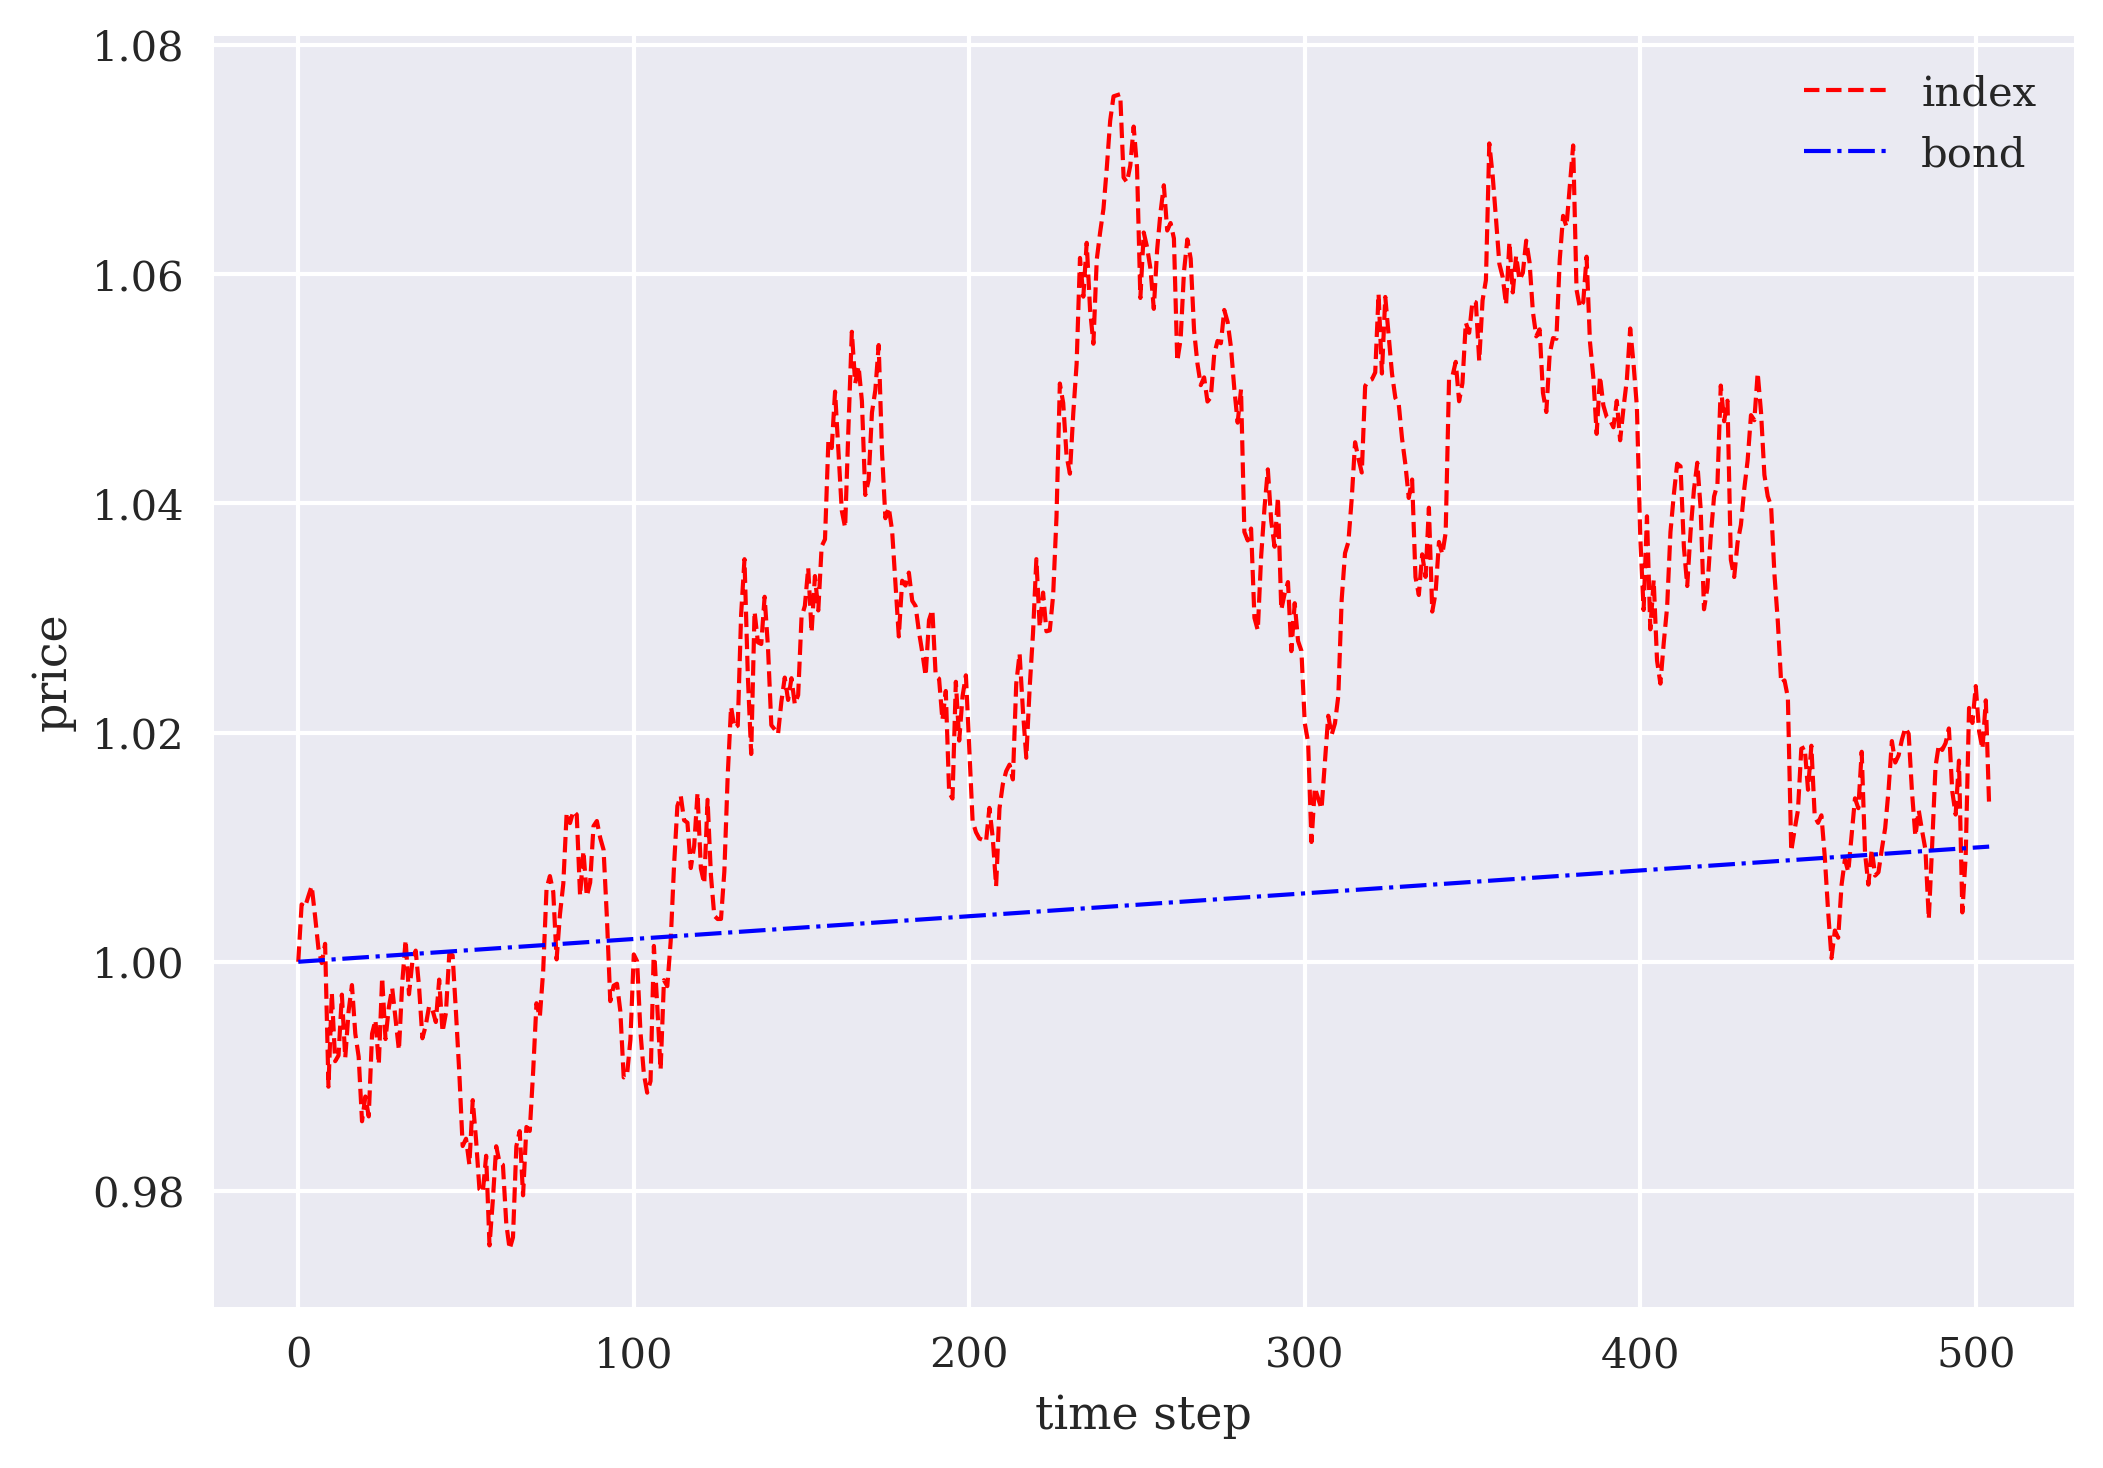

In [31]:
hedging._simulate_data()
(hedging.data / hedging.data.iloc[0]).plot(
    lw=1.0, style=['r--', 'b-.'])
plt.xlabel('time step')
plt.ylabel('price');

In [32]:
hedging.reset()
for _ in range(hedging.steps - 1):
    hedging.step(hedging.action_space.sample())

In [33]:
hedging.portfolios.head().round(4)

e       s        b     phi       C  p&l[$]  p&l[%]        St   Bt      K  \
0  1  0.2678 -22.4876  3.8871  3.7649  0.1222  3.2447   98.4880  1.0  110.0   
1  1  0.5623 -51.6103  4.7116  4.3306  0.3809  8.7957  100.1716  1.0  110.0   
2  1  0.5996 -55.7307  4.3350  4.3258  0.0092  0.2131  100.1789  1.0  110.0   
3  1  0.8360 -79.4251  4.7708  4.5103  0.2605  5.7760  100.7111  1.0  110.0   
4  1  0.0274   1.7478  4.5084  4.4776  0.0308  0.6877  100.6422  1.0  110.0   

   r  sigma  
0  0    0.2  
1  0    0.2  
2  0    0.2  
3  0    0.2  
4  0    0.2

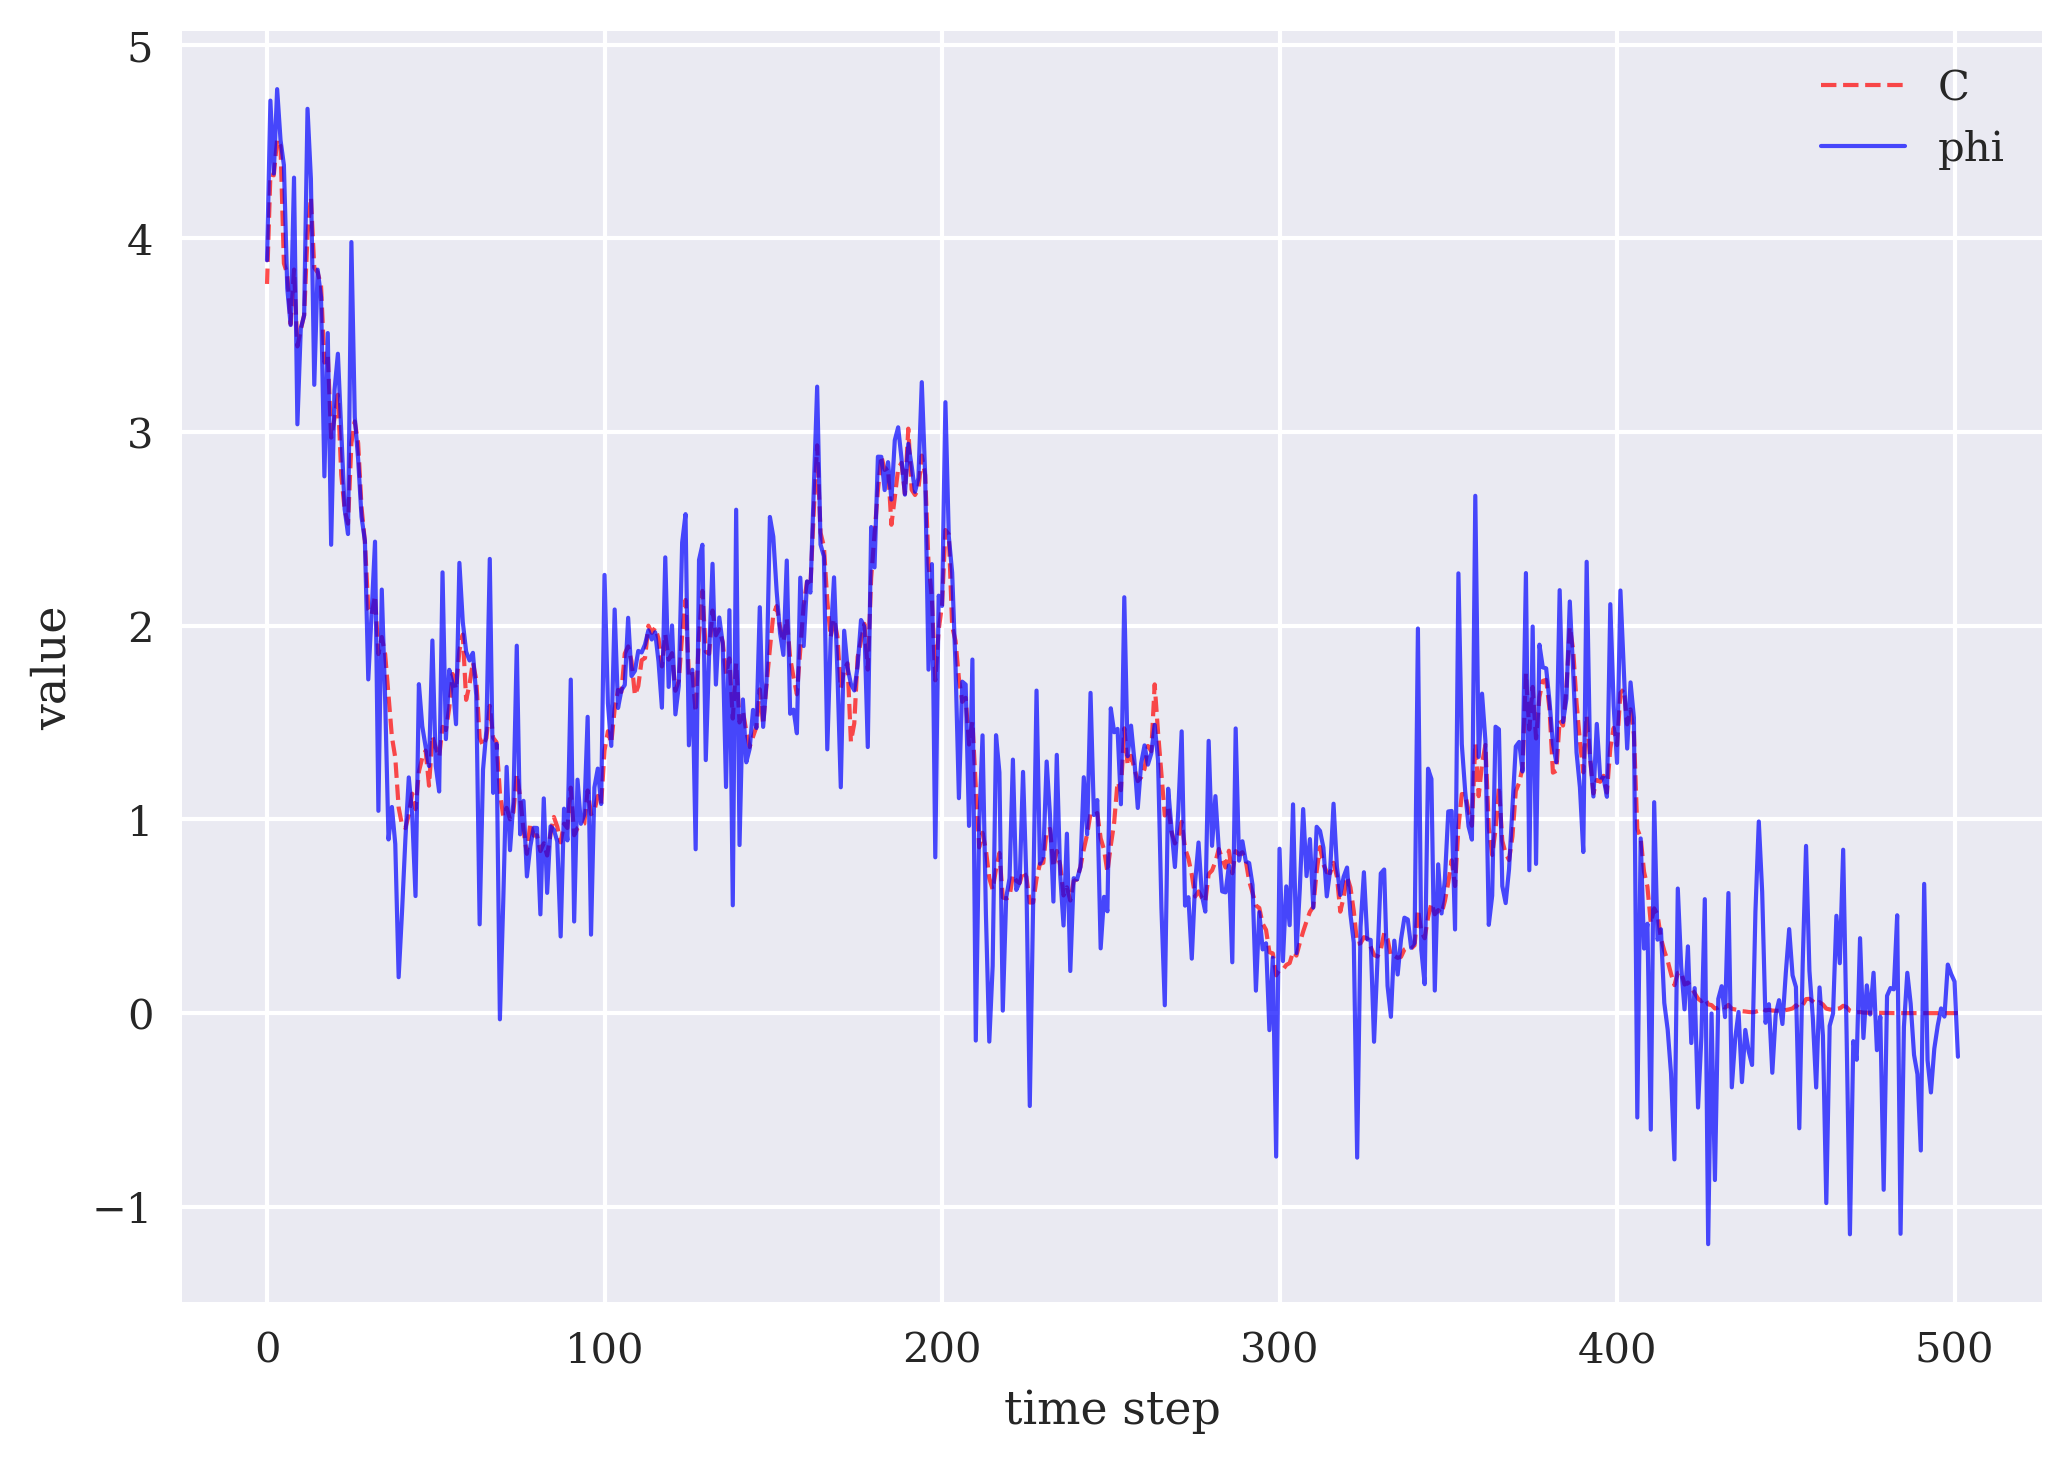

In [34]:
hedging.portfolios[['C', 'phi']].plot(
    style=['r--', 'b-'], lw=1, alpha=0.7)
plt.xlabel('time step')
plt.ylabel('value');

In [35]:
hedging.portfolios['p&l[$]'].apply(abs).sum()

133.4348359335141

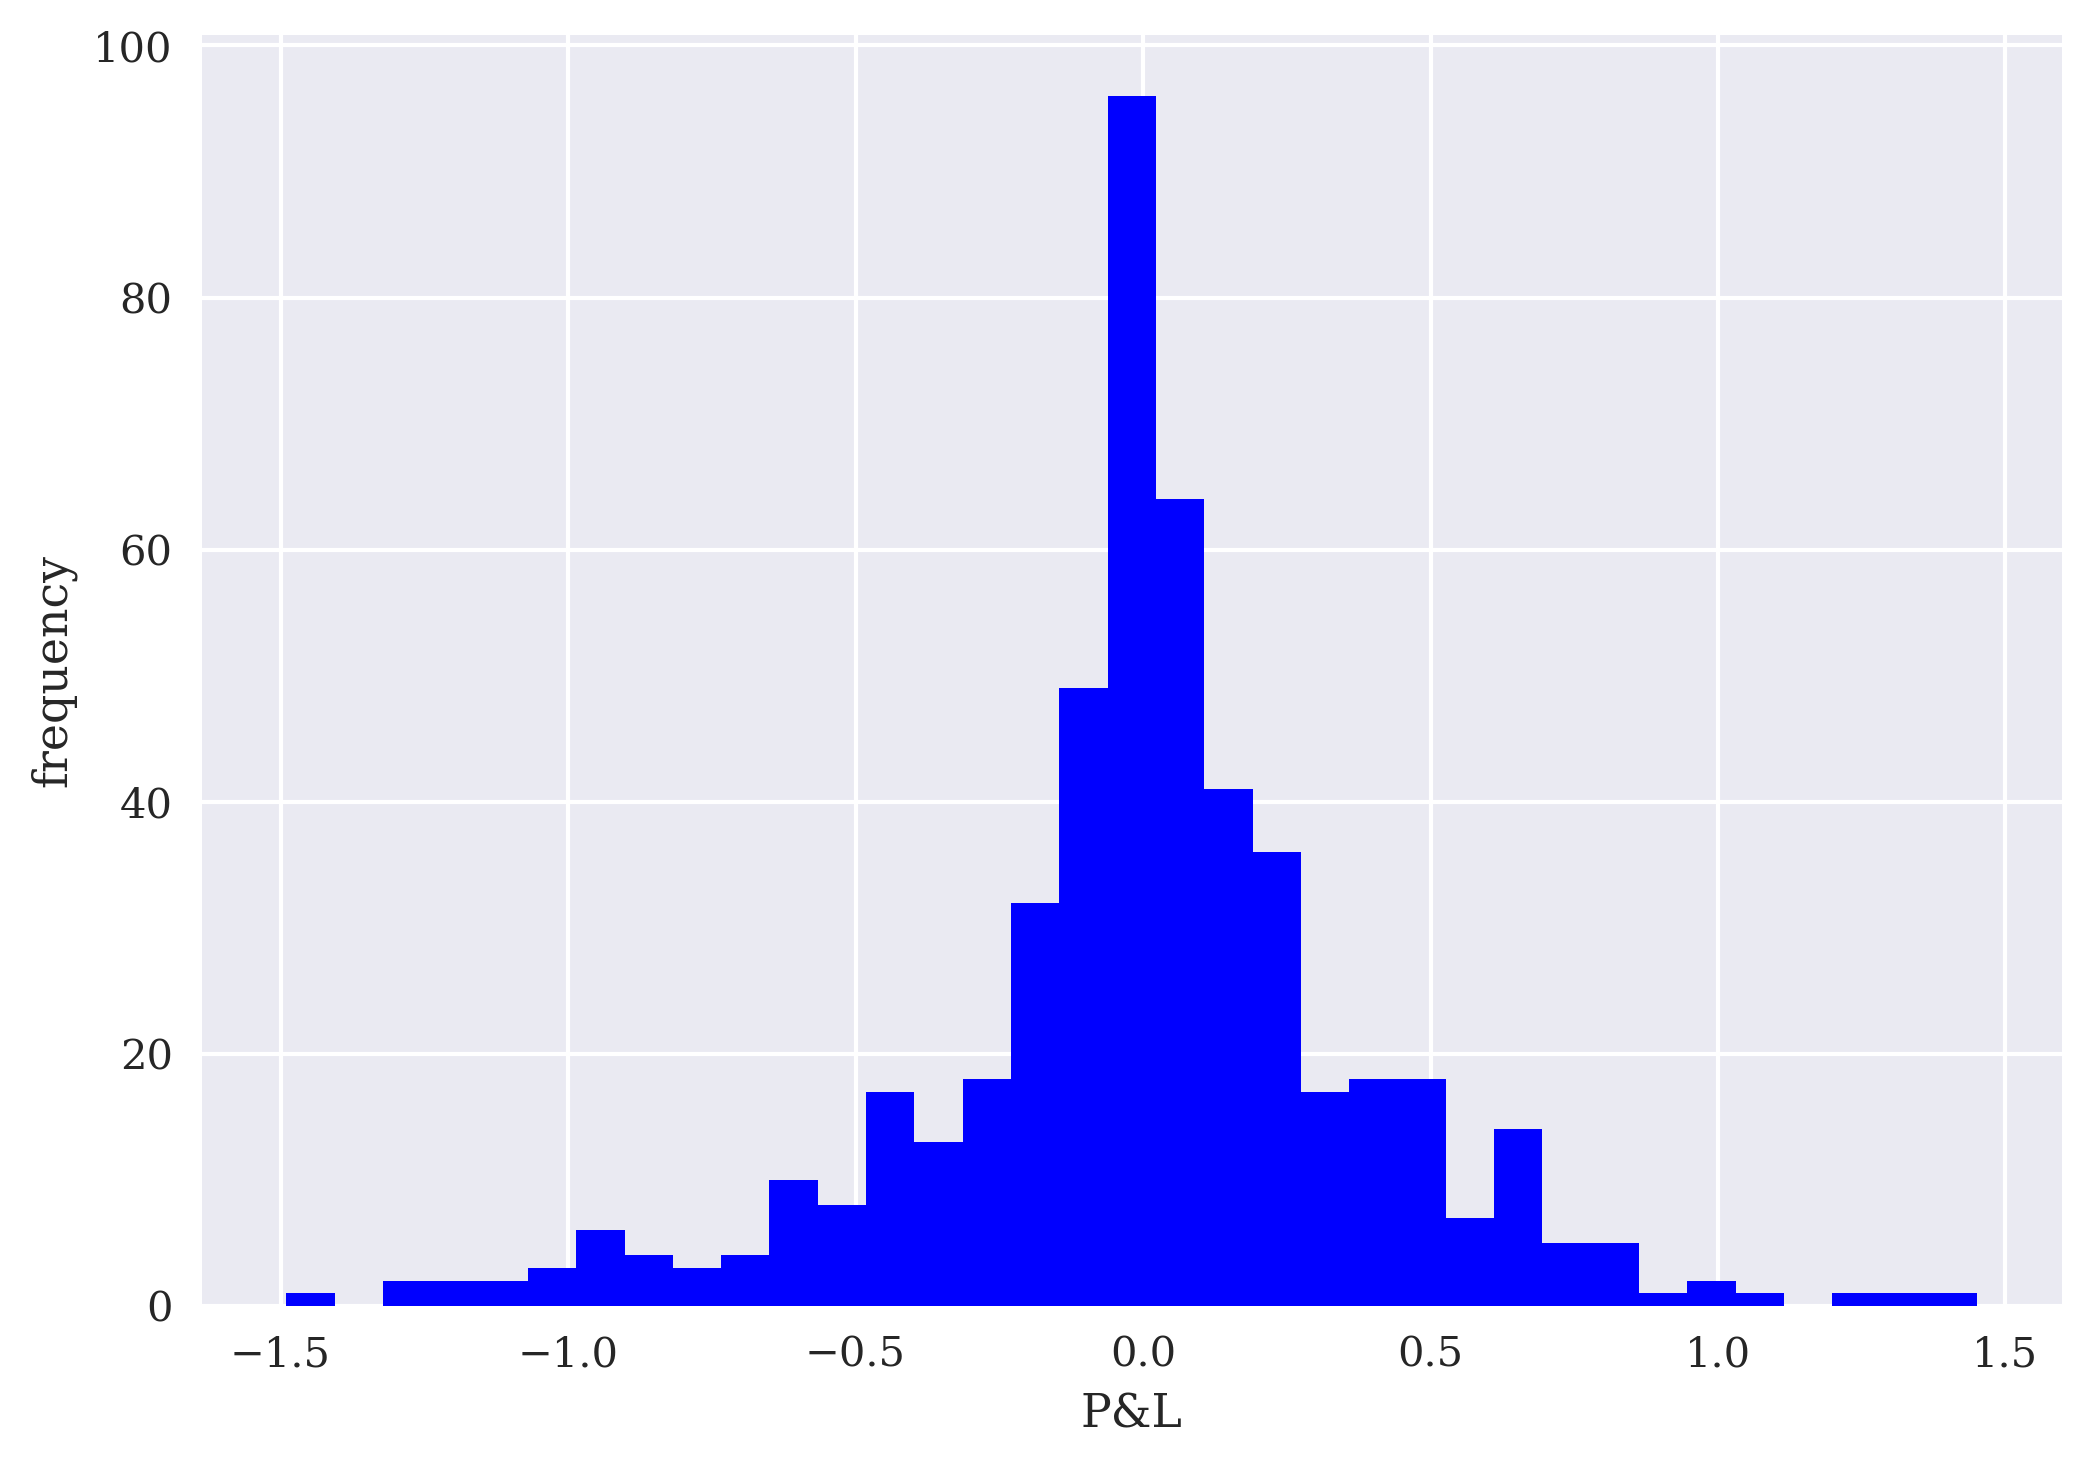

In [36]:
hedging.portfolios['p&l[$]'].hist(bins=35, color='b')
plt.xlabel('P&L')
plt.ylabel('frequency');

In [37]:
from dqlagent import *

In [38]:
random.seed(100)
tf.random.set_seed(100)

In [39]:
opt = keras.optimizers.legacy.Adam

## Specialized RL Agent for Dynamic Hedging

Now we create a **specialized Deep Q-Learning agent** designed specifically for the hedging problem. This extends our general DQLAgent with hedging-specific optimizations.

### Key Innovations in HedgingAgent:

**1. Continuous Action Space Handling:**
- Traditional DQL works with discrete actions
- Hedging requires continuous decisions (how many shares to hold)
- Solution: **Action optimization** using scipy.minimize

**2. Custom Action Selection:**
- `opt_action()`: Finds the optimal continuous action using the learned Q-function
- Treats the neural network as a value function
- Optimizes over possible actions to find the one with highest Q-value

**3. Hedging-Specific Reward Integration:**
- The agent learns to minimize squared hedging errors
- State representation includes current portfolio positions
- Action consequences are computed through portfolio mathematics

**4. Enhanced Replay Method:**
- Custom replay that handles continuous action optimization
- Updates target values using optimized actions from the target network
- Maintains the Bellman equation: Q(s,a) = r + γ × max Q(s',a')

### Why This Design Works:
- **Value Function Learning**: The network learns to evaluate different portfolio configurations
- **Action Optimization**: Mathematical optimization finds the best action given current value estimates
- **Experience Replay**: Learns from past hedging decisions across different market scenarios

This creates an agent that can learn sophisticated hedging strategies that go beyond traditional delta hedging.

In [40]:
class HedgingAgent(DQLAgent):
    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, input_dim=self.n_features,
                        activation='relu'))
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        self.model.compile(loss='mse',
                optimizer=opt(learning_rate=lr))

In [41]:
from scipy.optimize import minimize

In [42]:
class HedgingAgent(HedgingAgent):
    def opt_action(self, state):
        bnds = [(0, 1)]
        def f(state, x):
            s = state.copy()
            s[0, 6] = x
            s[0, 7] = ((s[0, 3] - x * s[0, 0]) / s[0, 1])
            return self.model.predict(s)[0, 0]
        try:
            action = minimize(lambda x: -f(state, x), 0.5,
                              bounds=bnds, method='Powell',
                             )['x'][0]
        except:
            action = self.env.stock
        return action
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        action = self.opt_action(state)
        return action

In [43]:
class HedgingAgent(HedgingAgent):
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, next_state, reward, done in batch:
            target = reward
            if not done:
                ns = next_state.copy()
                action = self.opt_action(ns)
                ns[0, 6] = action
                ns[0, 7] = ((ns[0, 3] -
                    action * ns[0, 0]) / ns[0, 1])
                target += (self.gamma *
                    self.model.predict(ns)[0, 0])
            self.model.fit(state, np.array([target]), epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [44]:
class HedgingAgent(HedgingAgent):
    def test(self, episodes, verbose=True):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, len(self.env.data) + 1):
                action = self.opt_action(state)
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    templ = f'total penalty={treward:4.2f}'
                    if verbose:
                        print(templ)
                    break

In [45]:
random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)

In [46]:
hedgingagent = HedgingAgent('SYM', feature=None, n_features=8,
                     env=hedging, hu=128, lr=0.0001)

In [47]:
episodes = 250

## Training the Hedging Agent

Now comes the critical phase: **training our RL agent** to learn optimal hedging strategies through experience.

### Training Process Overview:

**1. Experience Generation:**
- Agent hedges thousands of different options
- Random market scenarios (different volatilities, interest rates, strikes)
- Each episode = one complete hedging experience from option issuance to maturity

**2. Learning Mechanism:**
- **Exploration vs Exploitation**: ε-greedy policy balances trying new strategies vs using learned knowledge
- **Experience Replay**: Agent learns from past successful and failed hedging attempts
- **Value Function Updates**: Neural network learns to evaluate portfolio configurations

**3. Key Learning Challenges:**
- **Market Stochasticity**: Stock prices are random, but patterns exist
- **Parameter Generalization**: Agent must work across different option parameters
- **Risk Management**: Learning to minimize hedging errors consistently

**4. Training Hyperparameters:**
- **Episodes**: Number of complete hedging experiences
- **Neural Network**: Hidden layers learn complex hedging relationships
- **Learning Rate**: How quickly the agent adapts to new information
- **ε-decay**: Gradually shift from exploration to exploitation

### Expected Learning Outcomes:
- Agent should learn strategies that **outperform random hedging**
- Hedging errors should **decrease over time**
- Strategy should **generalize** to unseen market conditions

Watch the training progress - each episode teaches the agent something new about dynamic hedging!

In [48]:
%time hedgingagent.learn(episodes)

episode= 250 | treward=-15.000 | max= -7.8044
CPU times: user 17min 18s, sys: 3min 29s, total: 20min 47s
Wall time: 17min 41s


In [49]:
hedgingagent.epsilon

0.5348427211156283

In [50]:
%time hedgingagent.test(10)

total penalty=-10.61
total penalty=-9.11
total penalty=-1.26
total penalty=-4.90
total penalty=-2.79
total penalty=-7.03
total penalty=-7.55
total penalty=-3.15
total penalty=-17.08
total penalty=-19.22
CPU times: user 1min 52s, sys: 22.2 s, total: 2min 14s
Wall time: 1min 52s


## Analyzing RL Hedging Performance

Time to evaluate our trained agent! This is where we see if reinforcement learning can truly improve upon traditional hedging methods.

### Performance Evaluation Framework:

**1. Test Episodes:**
- Agent hedges new, unseen option scenarios
- No more learning (ε = 0, pure exploitation)
- Performance on "out-of-sample" data tests generalization

**2. Key Performance Metrics:**

**Hedging Error Analysis:**
- **Portfolio Value (φ)** vs **True Option Value (C)**
- **P&L Distribution**: How close is our replication?
- **Total Penalty**: Sum of squared hedging errors

**Comparative Analysis:**
- **RL Strategy** vs **Random Strategy** (baseline)
- **RL Strategy** vs **Traditional Delta Hedging** (theoretical benchmark)

**3. What Good Performance Looks Like:**
- **Low hedging errors**: Portfolio value closely tracks option value
- **Consistent performance**: Works across different market scenarios
- **Risk management**: Avoids large, catastrophic hedging failures

**4. Visualization Insights:**
- **Time series plots**: See how well portfolio tracks option value
- **P&L histograms**: Understand the distribution of hedging errors
- **Parameter sensitivity**: Performance across different strikes, volatilities

### Expected Results:
Our RL agent should demonstrate **superior risk management** compared to naive strategies, learning to adapt its hedging based on market conditions rather than following rigid mathematical formulas.

Let's see how our artificial intelligence performs in the complex world of derivatives hedging!

In [51]:
n = max(hedgingagent.env.portfolios['e'])
n -= 1

In [52]:
hedgingagent.env.portfolios[
    hedgingagent.env.portfolios['e'] == n]['p&l[$]'].describe()

count    503.000000
mean      -0.013716
std        0.183946
min       -0.883232
25%       -0.093197
50%       -0.000380
75%        0.068762
max        0.639175
Name: p&l[$], dtype: float64

In [53]:
p = hedgingagent.env.portfolios[
    hedgingagent.env.portfolios['e'] == n].iloc[0][
    ['K', 'r', 'sigma']]

In [54]:
title = f"CALL | K={p['K']:.1f} | r={p['r']} | sigma={p['sigma']}"

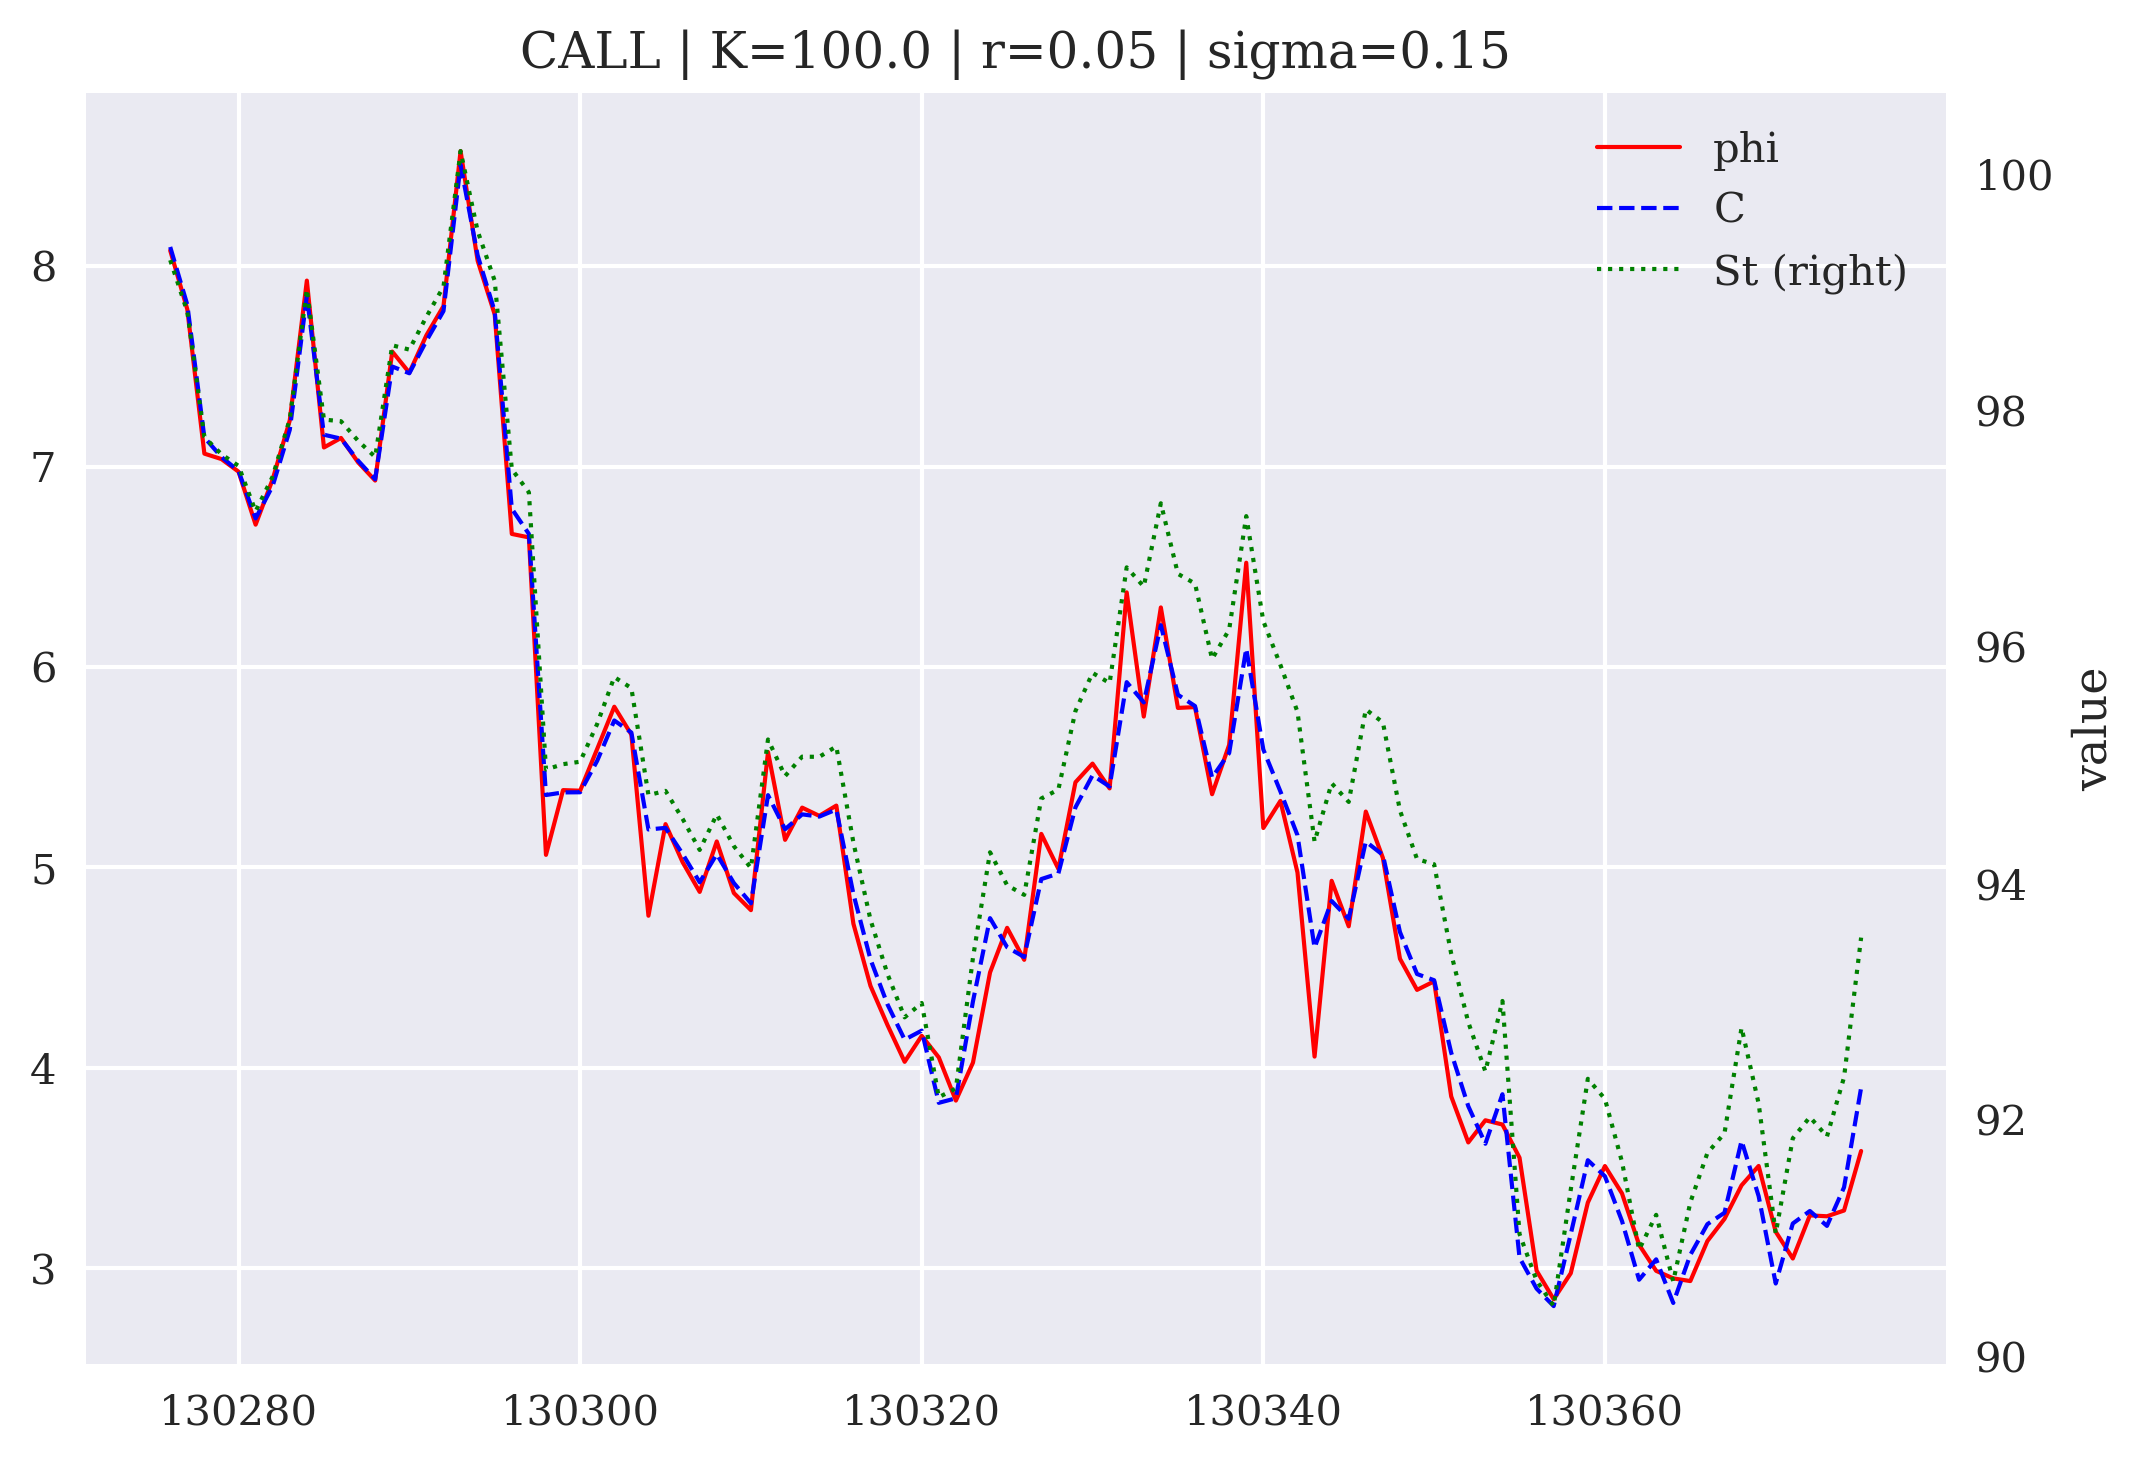

In [55]:
hedgingagent.env.portfolios[
    hedgingagent.env.portfolios['e'] == n][
    ['phi', 'C', 'St']].iloc[:100].plot(
    secondary_y='St', title=title, style=['r-', 'b--', 'g:'], lw=1)
plt.xlabel('time step')
plt.ylabel('value');

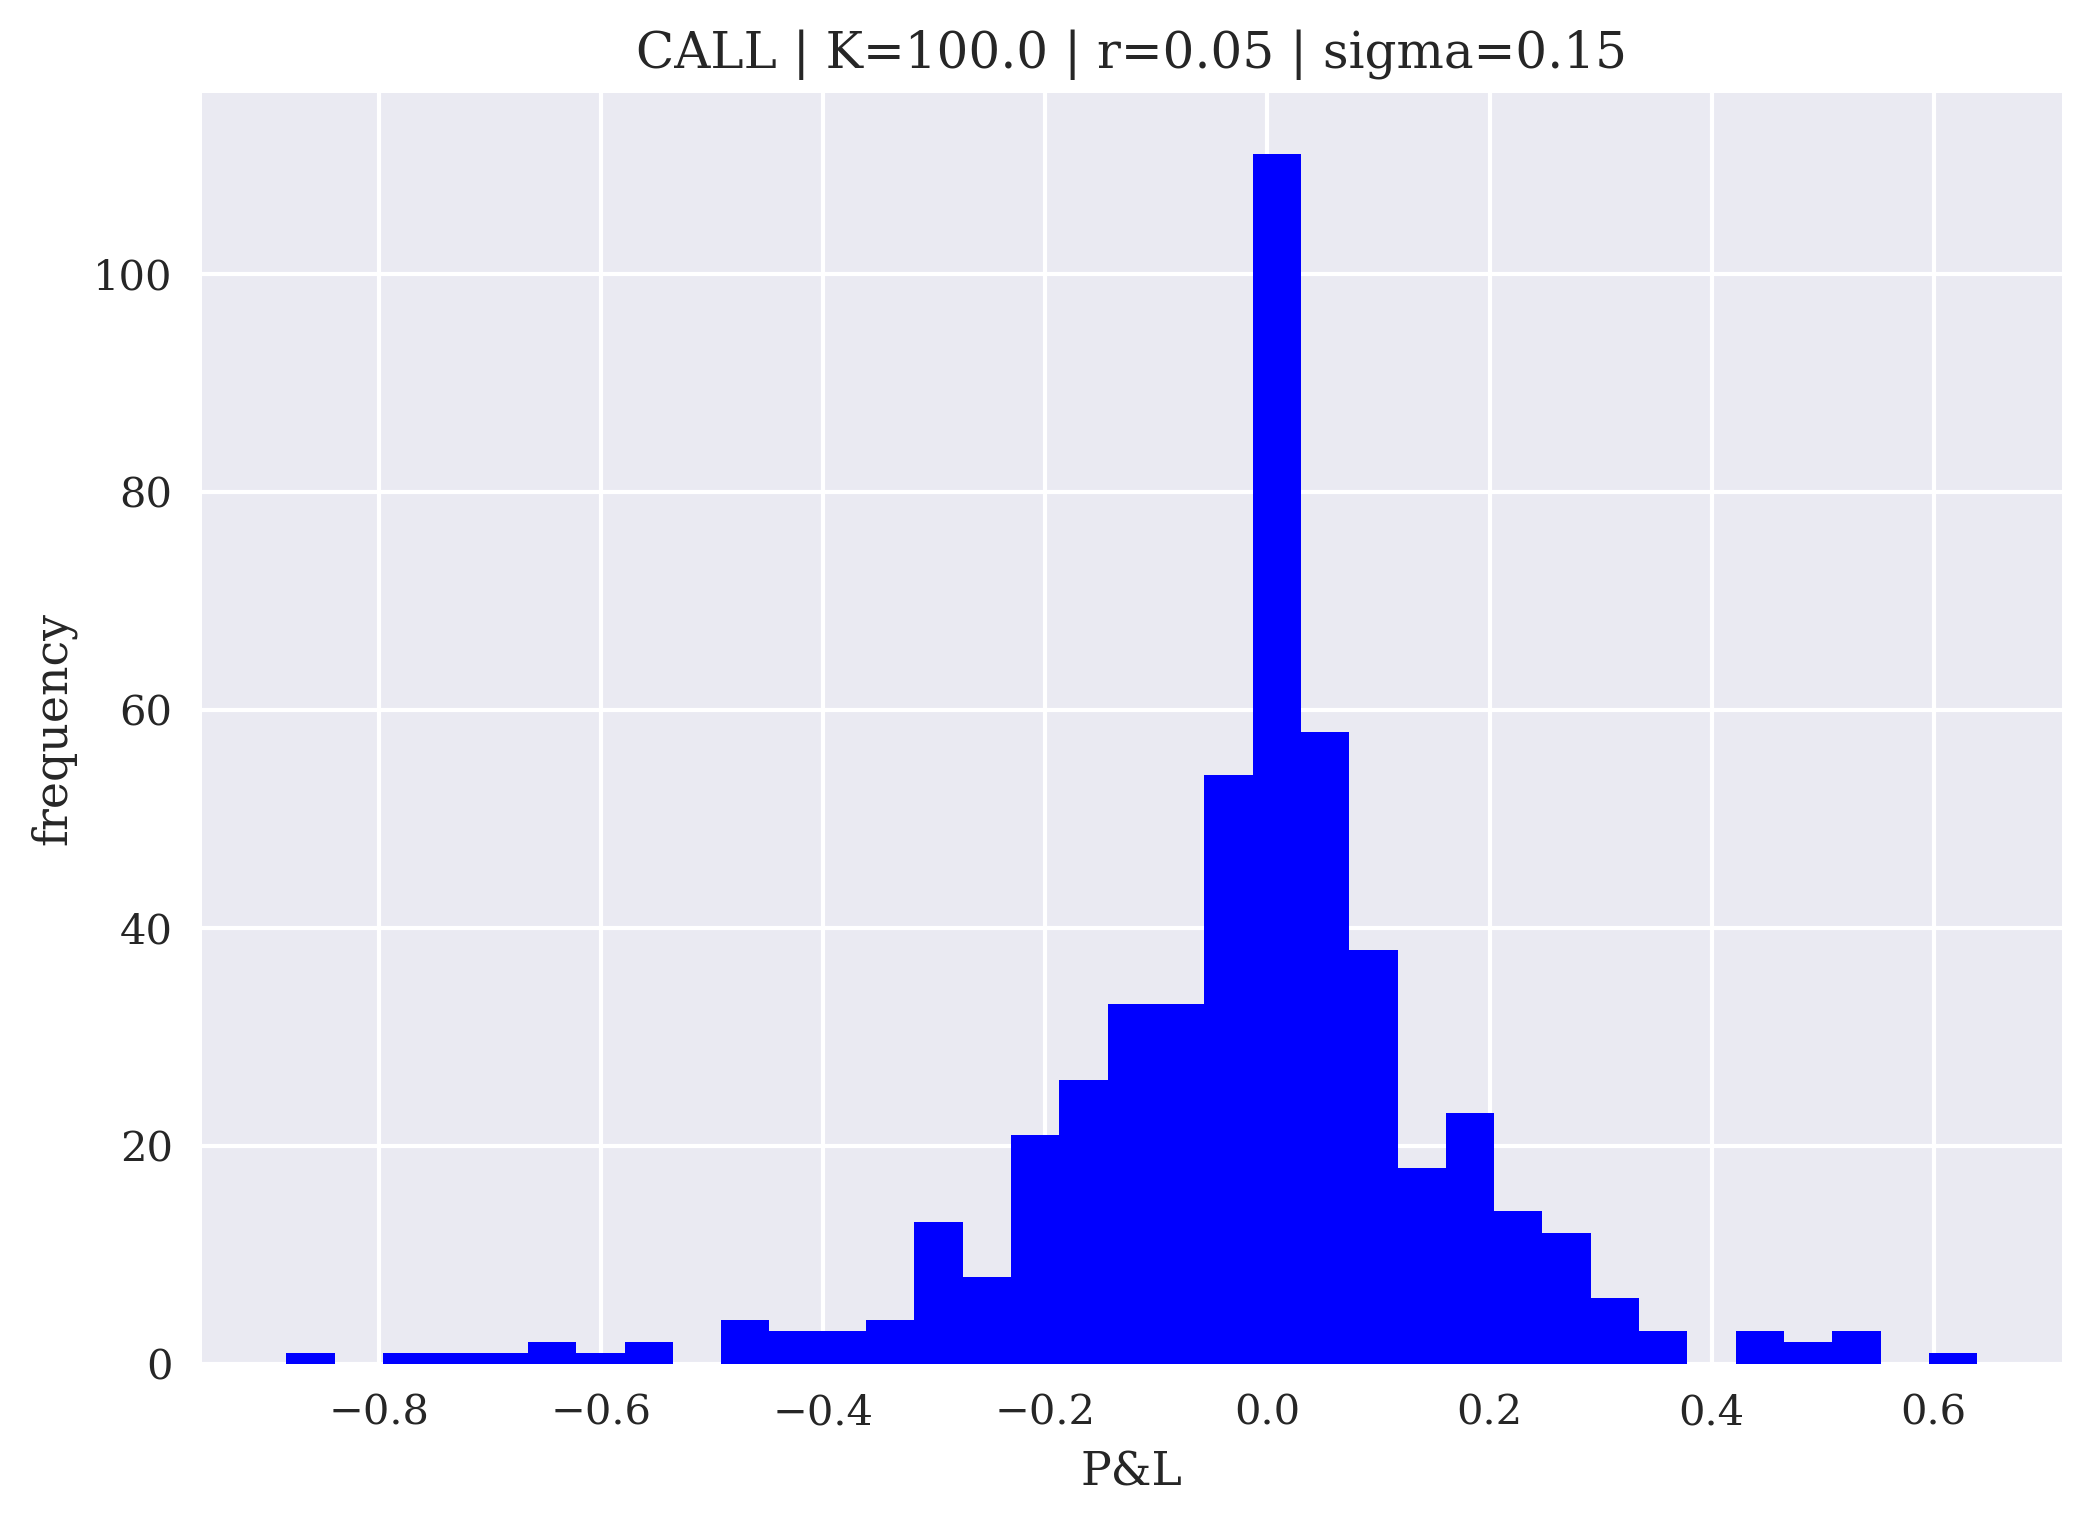

In [56]:
hedgingagent.env.portfolios[
    hedgingagent.env.portfolios['e'] == n]['p&l[$]'].hist(
        bins=35, color='blue')
plt.title(title)
plt.xlabel('P&L')
plt.ylabel('frequency');

<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>